In [28]:
import requests
import json
import pandas as pd
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# 2019/02/01～の情報を取得（UTCとの時差は9時間）（close_timeは日本時間で午前9時）
res = requests.get('https://api.cryptowat.ch/markets/bitflyer/btcjpy/ohlc?periods=86400&after=1548979200')
data = json.loads(res.text)
daily_data = pd.DataFrame(data['result']['86400'], columns=['close_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'quote_volume'])
daily_data['date'] = pd.to_datetime(daily_data['close_time'], unit='s')
daily_data = daily_data[:-1] # 最終行を削除（取得した時点の情報が次の日の情報となっているため）
daily_data.tail()

,close_time,open_price,high_price,low_price,close_price,volume,quote_volume,date
775,1615939200,6083180,6200000,5827000,6200000,9109.119704,5.485200e+10,2021-03-17
776,1616025600,6199369,6418220,5930000,6411597,7376.013318,4.530493e+10,2021-03-18
777,1616112000,6411831,6542130,6213860,6284358,6517.363058,4.161257e+10,2021-03-19
778,1616198400,6284358,6466720,6120527,6327712,5985.229138,3.794152e+10,2021-03-20
779,1616284800,6324830,6518061,6304720,6333656,4608.233095,2.955838e+10,2021-03-21


In [30]:
# レイアウトの作成
layout = go.Layout(
    height=700,
        xaxis={
            "rangeslider":{"visible":True},
            'rangeselector':{
                'buttons':[
                    {'label':'1週', 'step':'day', 'count':7},
                    {'label':'1月', 'step':'month', 'count':1},
                    {'label':'半年', 'step':'month', 'count':6},
                    {'label':'1年', 'step':'year', 'count':1}
                    #{'step':'all'}
                ]
            }
        }
)

# 実際の価格のグラフを作成
real_graph = go.Scatter(
    x=daily_data['date'], 
    y=daily_data['close_price'],
    name='実際の相場'
)

# グラフを描画
go.Figure(
    data=real_graph,
    layout=layout
).show()

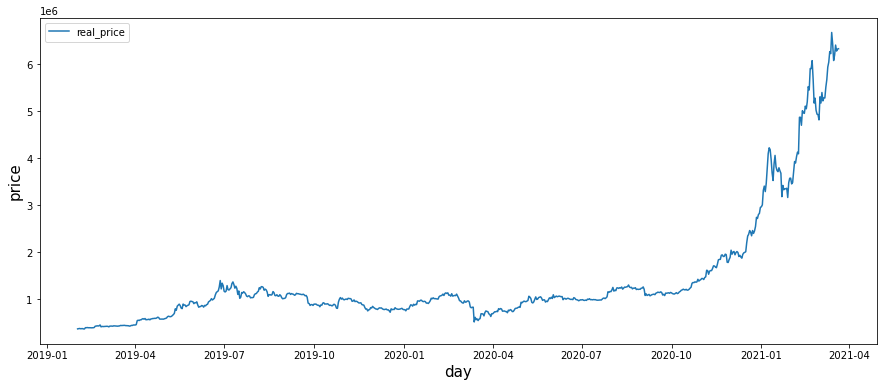

In [31]:
# グラフを描画
plt.figure(figsize=(15,6))
plt.plot(daily_data['date'], daily_data['close_price'], label="real_price")
plt.xlabel("day", fontsize=15)
plt.ylabel("price", fontsize=15)
plt.legend()
plt.show()

In [32]:
# 移動平均線を作成するためのデータを作成
daily_data['5ma'] = daily_data['close_price'].rolling(5, min_periods=1).mean() # ma→moving average（移動平均）
#daily_data['25ma'] = daily_data['close_price'].rolling(25, min_periods=1).mean()
#daily_data['bb_mean'] = daily_data['close_price'].rolling(window=10).mean()

# ボリンジャーバンド(2σ)を作成するためのデータを作成
daily_data['bb_std'] = daily_data['close_price'].rolling(window=5).std()
daily_data['bb_upper'] = daily_data['5ma'] + (daily_data['bb_std'] * 2)
daily_data['bb_lower'] = daily_data['5ma'] - (daily_data['bb_std'] * 2)
daily_data.tail()

,close_time,open_price,high_price,low_price,close_price,volume,quote_volume,date,5ma,bb_std,bb_upper,bb_lower
775,1615939200,6083180,6200000,5827000,6200000,9109.119704,5.485200e+10,2021-03-17,6324961.8,235095.375430,6.795153e+06,5.854771e+06
776,1616025600,6199369,6418220,5930000,6411597,7376.013318,4.530493e+10,2021-03-18,6361281.0,230744.460981,6.822770e+06,5.899792e+06
777,1616112000,6411831,6542130,6213860,6284358,6517.363058,4.161257e+10,2021-03-19,6282152.6,146629.510697,6.575412e+06,5.988894e+06
778,1616198400,6284358,6466720,6120527,6327712,5985.229138,3.794152e+10,2021-03-20,6261209.6,125798.520477,6.512807e+06,6.009613e+06
779,1616284800,6324830,6518061,6304720,6333656,4608.233095,2.955838e+10,2021-03-21,6311464.6,77366.107869,6.466197e+06,6.156732e+06


In [33]:
# 移動平均線を作成
mean_graph = go.Scatter(
    x=daily_data['date'], 
    y=daily_data['5ma'],
    line={'dash':'dash'},
    opacity=0.4,
    name='移動平均線'
)

# ボリンジャーバンドを作成
bb_upper = go.Scatter(
    x=daily_data['date'], 
    y=daily_data['bb_upper'],
    line={'dash':'dot'},
    opacity=0.3,
    name='ボリンジャーバンド（+2σ）'
)

# ボリンジャーバンドを作成
bb_lower = go.Scatter(
    x=daily_data['date'], 
    y=daily_data['bb_lower'],
    line={'dash':'dot'},
    opacity=0.3,
    name='ボリンジャーバンド（-2σ）'
)

# グラフを描画
go.Figure(
    data=[real_graph, mean_graph, bb_upper, bb_lower],
    layout=layout
).show()

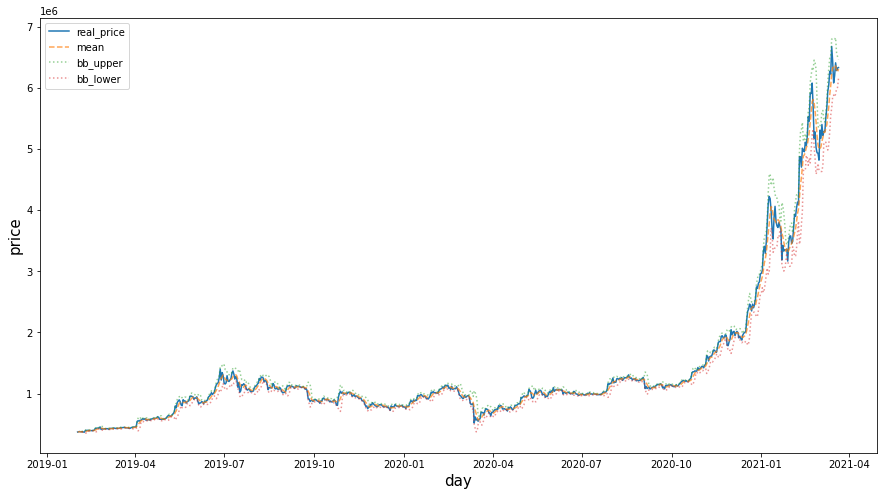

In [34]:
# グラフを描画
plt.figure(figsize=(15,8))
plt.plot(daily_data['date'], daily_data['close_price'], label="real_price")
plt.plot(daily_data['date'], daily_data['5ma'], linestyle="--", alpha=0.7, label="mean")
plt.plot(daily_data['date'], daily_data['bb_upper'], linestyle=":", alpha=0.5, label="bb_upper")
plt.plot(daily_data['date'], daily_data['bb_lower'], linestyle=":", alpha=0.5, label="bb_lower")
plt.xlabel("day", fontsize=15)
plt.ylabel("price", fontsize=15)
plt.legend()
plt.show()

In [35]:
#Keras
from __future__ import print_function
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.optimizers import Adam

#LSTM
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

In [36]:
# ハイパーパラメータ
period = 5

In [37]:
#データから変数とラベルを生成し、訓練データとテストデータに分割する
def getInputLabel(data, period=period, train_split_latio=0.9):
    period = period
    input_tensor = []
    label_tensor = []
    mean_list = []
    std_list = []
    data_len = len(data)    #総データ数
    
    #変数とラベルの生成
    for i in range(0, data_len - period, 1):
        window = data.values[i:i + period]
        mean = np.mean(window)
        std = np.std(window)
        mean_list.append(mean)
        std_list.append(std)
        input_tensor.append((window-mean) / std)
        label_tensor.append((data.values[i + period]-mean) / std)
        
    input_tensor = np.array(input_tensor).reshape(len(data)-period, period, 1)
    label_tensor = np.array(label_tensor).reshape(len(data)-period, 1)
    mean_list = np.array(mean_list)
    std_list = np.array(std_list)
    
    #訓練データとテストデータに分割
    border = int((data_len - period) * train_split_latio)    #分割境界値
    X_train, X_test = input_tensor[: border], input_tensor[border :]    #入力データ
    y_train, y_test = label_tensor[: border], label_tensor[border :]     #ラベルデータ
    mean_train, mean_test = mean_list[: border], mean_list[border :]
    std_train, std_test = std_list[: border], std_list[border :]
    
    return X_train, X_test, y_train, y_test, mean_train, mean_test, std_train, std_test

# 訓練データとテストデータを作成
data = daily_data['close_price']
X_train, X_test, y_train, y_test, mean_train, mean_test, std_train, std_test = getInputLabel(data = data)

In [38]:
# 日付データを整形
date = daily_data['date'][5:].reset_index(drop=True)
date.head()

0   2019-02-06
1   2019-02-07
2   2019-02-08
3   2019-02-09
4   2019-02-10
Name: date, dtype: datetime64[ns]

In [39]:
# 日付データを訓練データとテストデータに紐付ける関数を作成
def date_split(date, period=period, split_latio=0.9):
    date = date[period:].reset_index(drop=True)
    border = int(len(date) * split_latio)
    train_date, test_date = date[: border], date[border :].reset_index(drop=True)
    
    return train_date, test_date

# 日付データを訓練データとテストデータに分ける
train_date, test_date = date_split(date = daily_data['date'])
test_date.tail()

73   2021-03-17
74   2021-03-18
75   2021-03-19
76   2021-03-20
77   2021-03-21
Name: date, dtype: datetime64[ns]

In [40]:
# LSTMのモデルを作成する関数を作成
def create_LSTM(hidden_size=20, dropout=0.5, output_size=1):
    model = Sequential()
    model.add(LSTM(hidden_size,
                 #dropout=0.2,
                 input_shape=(5, 1)))   # batch_input_shape = (None, 5, 1)でもいい
    #model.add(Dense(5, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, activation='linear'))
    #model.add(Activation("linear"))
    model.compile(optimizer='adam',
               loss='mse',
               metrics=['mae'])
    model.summary()

    return model

In [41]:
# 学習
early_stopping = EarlyStopping(monitor='loss', patience=5)
model = create_LSTM()
model.fit(X_train, y_train, batch_size = 5, epochs = 10, verbose = 2,  shuffle = True, callbacks = [early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 4s - loss: 6.5339 - mean_absolute_error: 1.6936
Epoch 2/10
 - 2s - loss: 5.7885 - mean_absolute_error: 1.5141
Epoch 3/10
 - 2s - loss: 5.5894 - mean_absolute_error: 1.4653
Epoch 4/10
 - 2s - loss: 5.5386 - mean_absolute_error: 1.4370
Epoch 5/10
 - 2s - loss: 5.5686 - mean_absolute_error: 1.4543
Epoch 6/10
 - 2s - loss: 5.4817 - mean_absolute_error: 1.4513
Epoch 7/10
 - 2s - loss: 5.5420 

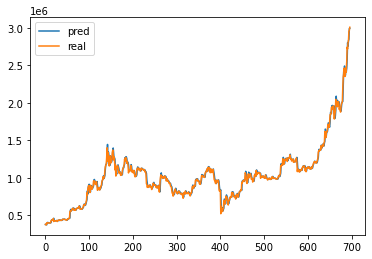

In [42]:
# 訓練データでの予測結果と実際の相場のグラフを描画
pred_train = model.predict(X_train)
pred_train = pred_train.reshape(-1)
pred_train = pred_train*std_train + mean_train
y_train = y_train.reshape(-1)
real_train = y_train*std_train + mean_train
train_result = pd.DataFrame({'pred':pred_train, 'real':real_train})   
train_result.plot()
plt.show()

In [43]:
#訓練データの騰落正答率を計算
train_score = 0
length = len(pred_train)-1
for i in range(length):
    if (real_train[i+1] - real_train[i]) > 0  and (pred_train[i+1] - real_train[i]) > 0:
        train_score += 1
    elif (real_train[i+1] - real_train[i]) < 0  and (pred_train[i+1] - real_train[i]) < 0:
        train_score += 1

print("train_score = %s"%((train_score / length) * 100))

train_score = 57.04022988505747


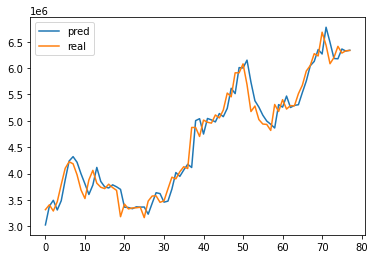

In [44]:
#テストデータでの予測結果と実際の相場のグラフを描画
pred_test = model.predict(X_test) #テストデータ予測
pred_test = pred_test.reshape(-1) #1次元に変形
y_test = y_test.reshape(-1)
pred_test = pred_test*std_test + mean_test # 標準化したデータを戻す
real_test = y_test*std_test + mean_test
test_result = pd.DataFrame({'pred':pred_test, 'real':real_test})   
test_result.plot()
plt.show()

In [45]:
#testデータ騰落正答確率測定
test_score = 0
test_length = len(pred_test)-1
for i in range(test_length):
    if (real_test[i+1] - real_test[i]) > 0  and (pred_test[i+1] - real_test[i]) > 0:
        test_score += 1
    elif (real_test[i+1] - real_test[i]) < 0  and (pred_test[i+1] - real_test[i]) < 0:
        test_score += 1

print("test_score = %s"%((test_score / test_length) * 100))

test_score = 53.246753246753244


In [46]:
import pickle

# modelをpikcle
# 学習済みモデルを保存    
with open("lstm_model.pickle", "wb") as f:
    pickle.dump(model, f)

In [47]:
#train_resultデータフレームに日付データを追加
train_result['date'] = train_date
train_result.tail()

,pred,real,date
692,2.757459e+06,2805138.0,2020-12-29
693,2.831016e+06,2827970.0,2020-12-30
694,2.849506e+06,2957123.0,2020-12-31
695,2.992856e+06,2968795.0,2021-01-01
696,2.997384e+06,3010042.0,2021-01-02


In [48]:
#test_resultデータフレームに日付データを追加
test_result['date'] = test_date
test_result.tail()

,pred,real,date
73,6.181549e+06,6200000.0,2021-03-17
74,6.176060e+06,6411597.0,2021-03-18
75,6.361522e+06,6284358.0,2021-03-19
76,6.322145e+06,6327712.0,2021-03-20
77,6.338235e+06,6333656.0,2021-03-21


In [49]:
# train_resultとtest_resultを結合
predict = pd.concat([train_result, test_result])
predict = predict.reset_index(drop=True)
predict.tail()

,pred,real,date
770,6.181549e+06,6200000.0,2021-03-17
771,6.176060e+06,6411597.0,2021-03-18
772,6.361522e+06,6284358.0,2021-03-19
773,6.322145e+06,6327712.0,2021-03-20
774,6.338235e+06,6333656.0,2021-03-21


In [50]:
# 翌日の相場を予測するためのwindowを作成
will_input = predict['real'][-period:]
will_input = np.array(will_input).reshape(1, period, 1)

# 標準化
input_mean = np.mean(will_input)
input_std = np.std(will_input)
sta_input = (will_input - input_mean) / input_std
sta_input

array([[[-1.61079851],
        [ 1.44703449],
        [-0.39172321],
        [ 0.23479461],
        [ 0.32069262]]])

In [51]:
# 翌日の相場を予測、標準化してあるので元に戻す
future_price = model.predict(sta_input)
future_price = future_price.reshape(-1)
future_price = future_price*input_std + input_mean
future_price = float(future_price)
future_price

6350886.5

In [52]:
# 翌日の日付を取得
today = predict['date'][-1:]
next_day = today + timedelta(days=1)
next_day = next_day.values[0] 
next_day

numpy.datetime64('2021-03-22T00:00:00.000000000')

In [53]:
predict.tail()

,pred,real,date
770,6.181549e+06,6200000.0,2021-03-17
771,6.176060e+06,6411597.0,2021-03-18
772,6.361522e+06,6284358.0,2021-03-19
773,6.322145e+06,6327712.0,2021-03-20
774,6.338235e+06,6333656.0,2021-03-21


In [54]:
# 翌日の日付、予測した価格をデータフレームに格納
df = predict.append({'pred':future_price, 'date':next_day}, ignore_index=True)
df.tail()

,pred,real,date
771,6.176060e+06,6411597.0,2021-03-18
772,6.361522e+06,6284358.0,2021-03-19
773,6.322145e+06,6327712.0,2021-03-20
774,6.338235e+06,6333656.0,2021-03-21
775,6.350886e+06,NaN,2021-03-22


In [55]:
# 予測した相場のグラフを作成
pred_graph = go.Scatter(
    x=df['date'], 
    y=df['pred'],
    name='predict'
)

# 実際の相場のグラフを作成
real_graph = go.Scatter(
    x=df['date'], 
    y=df['real'],
    name='real'
)

# グラフを描画
go.Figure(
    data=[real_graph, pred_graph],
    layout=layout
).show()